In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import random

In [2]:
## Where are we working
proj_dir = '/Users/zstanley/Documents/git_repos/obs_loc_for_scda'
plot_dir = proj_dir + '/plots'
my_data_dir = proj_dir + '/my_data'
nb_dir = proj_dir + '/notebooks'

In [3]:
cd /Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts

/Users/zstanley/Documents/git_repos/obs_loc_for_scda/scripts


In [4]:
from letkf import *

In [5]:
random.seed(21564)

In [6]:
## Which vertical columns are we considering here?
which_columns = {
  'lons' : [-174.5, 45.5, 75.5, -129.5, 160.5],
  'lats' : [-29.5, -59.5, -24.5, 0.5, 40.5],
  'name' : ['South Pacific', 'Southern Ocean', 'Indian Ocean', 'Tropical Pacific', 'North Pacific'],
  'save_name' : ['south_pacific', 'southern_ocean', 'indian_ocean', 'tropical_pacific', 'north_pacific']
}

In [7]:
# Load covariance matrices

# South Pacific
sp_cov = np.load(my_data_dir +'/south_pacific_cov.npy')
sp_cov = sp_cov[64:, 64:]
sp_cov_sqrt = np.linalg.cholesky(sp_cov)

# Southern Ocean
so_cov = np.load(my_data_dir +'/southern_ocean_cov.npy')
so_cov = so_cov[64:, 64:]
so_cov_sqrt = np.linalg.cholesky(so_cov)

# Indian Ocean
io_cov = np.load(my_data_dir +'/indian_ocean_cov.npy')
io_cov = io_cov[64:, 64:]
io_cov_sqrt = np.linalg.cholesky(io_cov)

# Tropical Pacific
tp_cov = np.load(my_data_dir +'/tropical_pacific_cov.npy')
tp_cov = tp_cov[64:, 64:]
tp_cov_sqrt = np.linalg.cholesky(tp_cov)

# North Pacific
np_cov = np.load(my_data_dir +'/north_pacific_cov.npy')
np_cov = np_cov[64:, 64:]
np_cov_sqrt = np.linalg.cholesky(np_cov)

In [8]:
# Get covariance matrix
this_cov = io_cov
this_cov_sqrt = io_cov_sqrt
num_levs = this_cov.shape[0]

In [9]:
# Get correlation matrix
io_cor = np.load(my_data_dir +'/indian_ocean_cor.npy')
io_cor = io_cor[64:, 64:]
this_cor = io_cor

In [10]:
## Set observation operator
HofX = np.zeros((1, num_levs))
HofX[0, 0] = 1

In [11]:
## Get state and observation positions and localization radii
ocn_z = np.load(my_data_dir+'/ocn_z.npy')
pos_state = ocn_z
pos_ob = pos_state[0]

In [188]:
## Generate synthetic observations
xt = this_cov_sqrt @ np.random.normal(size=(num_levs, 1))
#y_ob = HofX @ xt 
y_ob = HofX @ this_cov_sqrt @ np.random.normal(xt, scale=1, size=xt.shape)

In [41]:
## Set localization radius
loc_rad = 50
loc_rad_state = np.full_like(pos_state, loc_rad)
loc_rad_ob = np.full_like(pos_ob, loc_rad)

In [87]:
# Set ensemble size
ens_size = 20

In [88]:
## Generate ensemble
rnd = np.random.normal(size=(num_levs, ens_size))
x_ens = this_cov_sqrt @ rnd
P_ens = np.cov(x_ens)
C_ens = np.corrcoef(x_ens)

In [89]:
## Set observation error variance equal to background error variance
R = HofX @ P_ens @ HofX.transpose()
R_inv = np.reciprocal(R)

In [189]:
## Get analysis mean
analysis_mean, analysis_cov = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, np.full_like(pos_state, 1e5), np.full_like(pos_ob, 1e5), inflate=1, use_loc=False)
analysis_mean_loc, analysis_cov_loc = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, loc_rad_state, loc_rad_ob, inflate=1)

In [190]:
## Calculate analysis increments
background_mean = np.mean(x_ens, 1)
true_increment = xt[:,0] - background_mean
da_increment = analysis_mean - background_mean
da_increment_loc = analysis_mean_loc - background_mean
innovation = y_ob - HofX @ background_mean
kalman_gain = da_increment / innovation
enkf_increment = (P_ens[0,:]/(2*P_ens[0,0])) * innovation # Note this is not a general formula!
kf_increment = (this_cov[0,:]/(2*this_cov[0,0])) * innovation # Note this is not a general formula!

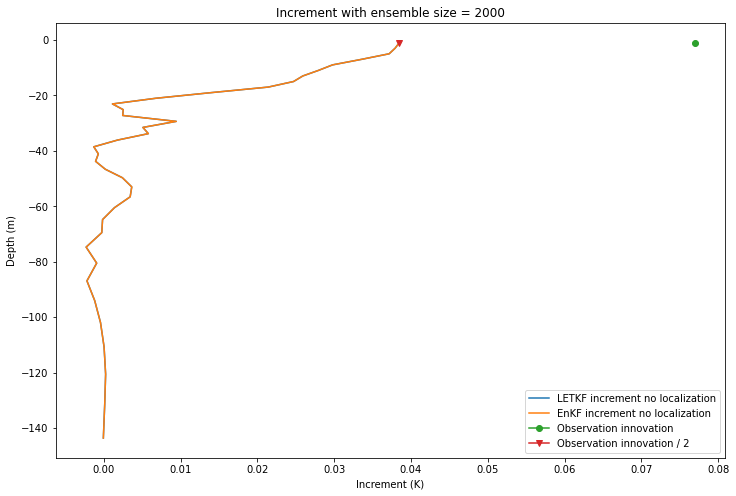

In [83]:
## Plot increment and observation
plt.plot(da_increment[:37], pos_state[:37], label='LETKF increment no localization')
plt.plot(enkf_increment[0, :37], pos_state[:37], label='EnKF increment no localization')
plt.plot(innovation, pos_ob, marker='o', label='Observation innovation')
plt.plot(innovation/2, pos_ob, marker='v', label='Observation innovation / 2')
plt.legend()
plt.xlabel('Increment (K)')
plt.ylabel('Depth (m)')
plt.title('Increment with ensemble size = '+str(ens_size))

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/ocn_increment_letkf_vs_enkf_150m_ens_size_'+str(ens_size))
plt.show()

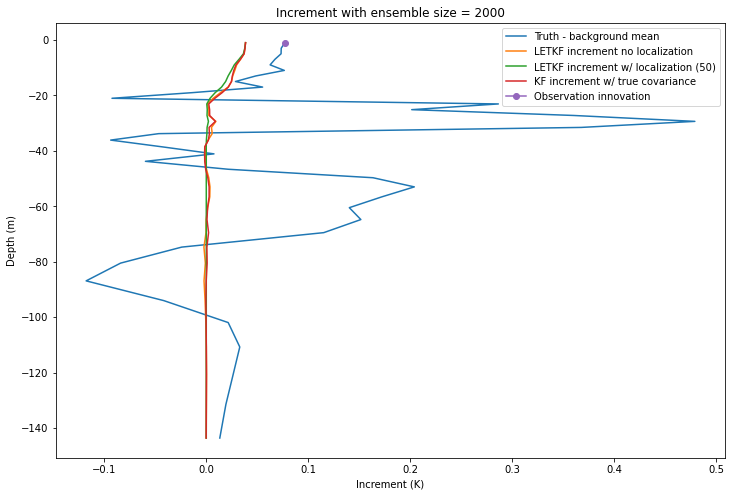

In [84]:
## Plot increment and observation
plt.plot(true_increment[:37], pos_state[:37], label='Truth - background mean')
plt.plot(da_increment[:37], pos_state[:37], label='LETKF increment no localization')
plt.plot(da_increment_loc[:37], pos_state[:37], label='LETKF increment w/ localization ('+str(loc_rad)+')')
plt.plot(kf_increment[0,:37], pos_state[:37], label='KF increment w/ true covariance')
plt.plot(innovation, pos_ob, marker='o', label='Observation innovation')
plt.legend()
plt.xlabel('Increment (K)')
plt.ylabel('Depth (m)')
plt.title('Increment with ensemble size = '+str(ens_size))

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/ocn_increment_150m_ens_size_'+str(ens_size))
plt.show()

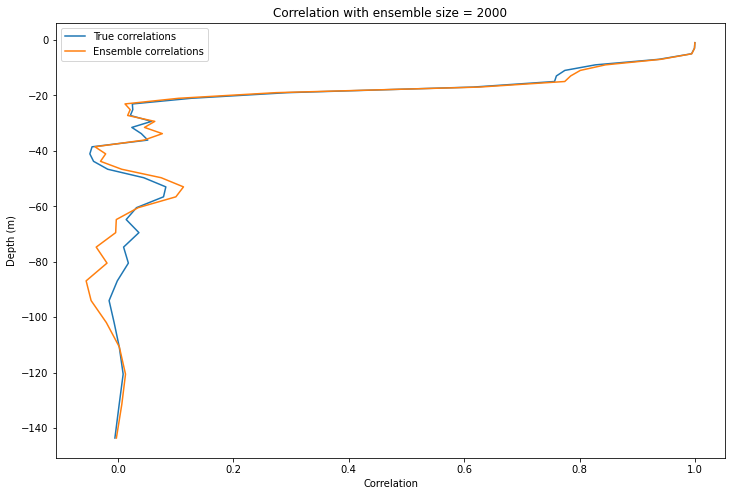

In [85]:
## Plot ensemble and true correlations
plt.plot(this_cor[0, :37], pos_state[:37], label='True correlations')
plt.plot(C_ens[0, :37], pos_state[:37], label='Ensemble correlations')
plt.legend()
plt.xlabel('Correlation')
plt.ylabel('Depth (m)')
plt.title('Correlation with ensemble size = '+str(ens_size))

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/ocn_corr_150m_ens_size_'+str(ens_size))
plt.show()

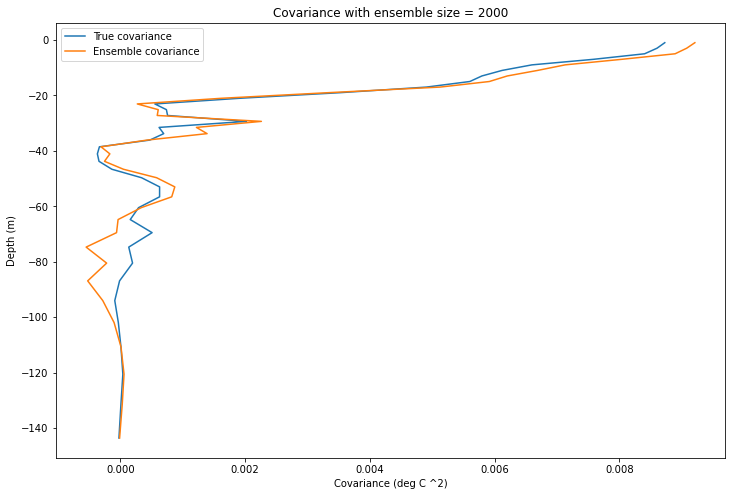

In [86]:
## Plot ensemble and true covariance
plt.plot(this_cov[0, :37], pos_state[:37], label='True covariance')
plt.plot(P_ens[0, :37], pos_state[:37], label='Ensemble covariance')
plt.legend()
plt.xlabel('Covariance (deg C ^2)')
plt.ylabel('Depth (m)')
plt.title('Covariance with ensemble size = '+str(ens_size))

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/ocn_cov_150m_ens_size_'+str(ens_size))
plt.show()

In [191]:
## Get analysis mean with differen localization radii
analysis_mean_no_loc, analysis_cov_no_loc = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, np.full_like(pos_state, 1e5), np.full_like(pos_ob, 1e5), inflate=1, use_loc=False)
analysis_mean_loc1, analysis_cov_loc1 = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, np.full_like(pos_state, 1), np.full_like(pos_ob, 1), inflate=1)
analysis_mean_loc5, analysis_cov_loc5 = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, np.full_like(pos_state, 5), np.full_like(pos_ob, 5), inflate=1)
analysis_mean_loc20, analysis_cov_loc20 = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, np.full_like(pos_state, 20), np.full_like(pos_ob, 20), inflate=1)
analysis_mean_loc30, analysis_cov_loc30 = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, np.full_like(pos_state, 30), np.full_like(pos_ob, 30), inflate=1)
analysis_mean_loc40, analysis_cov_loc40 = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, np.full_like(pos_state, 40), np.full_like(pos_ob, 40), inflate=1)
analysis_mean_loc50, analysis_cov_loc50 = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, np.full_like(pos_state, 50), np.full_like(pos_ob, 50), inflate=1)
analysis_mean_loc100, analysis_cov_loc100 = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, np.full_like(pos_state, 100), np.full_like(pos_ob, 100), inflate=1)

In [192]:
analysis_mean_loc60, analysis_cov_loc60 = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, np.full_like(pos_state, 60), np.full_like(pos_ob, 60), inflate=1)
analysis_mean_loc70, analysis_cov_loc70 = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, np.full_like(pos_state, 70), np.full_like(pos_ob, 70), inflate=1)
analysis_mean_loc80, analysis_cov_loc80 = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, np.full_like(pos_state, 80), np.full_like(pos_ob, 80), inflate=1)
analysis_mean_loc90, analysis_cov_loc90 = letkf_one_domain(x_ens, HofX, R_inv, y_ob, pos_state, pos_ob, np.full_like(pos_state, 90), np.full_like(pos_ob, 90), inflate=1)

In [193]:
## Calculate analysis increments
background_mean = np.mean(x_ens, 1)
inc_no_loc = analysis_mean_no_loc - background_mean
inc_loc1 = analysis_mean_loc1 - background_mean
inc_loc5 = analysis_mean_loc5 - background_mean
inc_loc20 = analysis_mean_loc20 - background_mean
inc_loc30 = analysis_mean_loc30 - background_mean
inc_loc40 = analysis_mean_loc40 - background_mean
inc_loc50 = analysis_mean_loc50 - background_mean
inc_loc60 = analysis_mean_loc60 - background_mean
inc_loc70 = analysis_mean_loc70 - background_mean
inc_loc80 = analysis_mean_loc80 - background_mean
inc_loc90 = analysis_mean_loc90 - background_mean
inc_loc100 = analysis_mean_loc100 - background_mean
innovation = y_ob - HofX @ background_mean
kf_increment = (this_cov[0,:]/(2*this_cov[0,0])) * innovation # Note this is not a general formula!

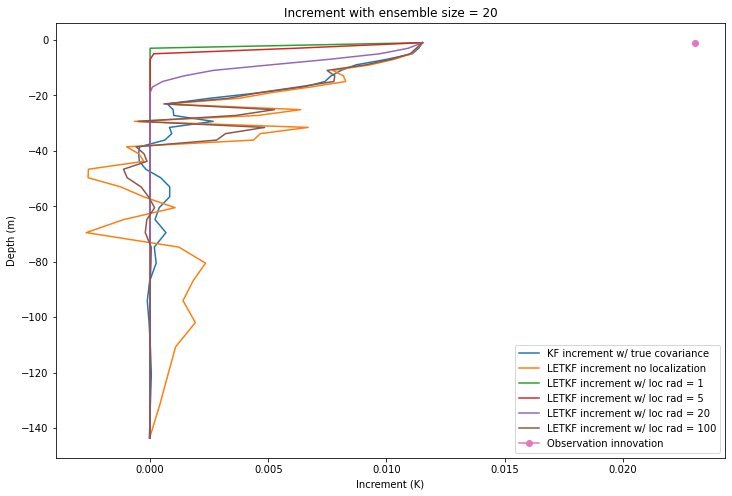

In [194]:
## Plot increment and observation
plt.plot(kf_increment[0,:37], pos_state[:37], label='KF increment w/ true covariance')
plt.plot(inc_no_loc[:37], pos_state[:37], label='LETKF increment no localization')
plt.plot(inc_loc1[:37], pos_state[:37], label='LETKF increment w/ loc rad = 1')
plt.plot(inc_loc5[:37], pos_state[:37], label='LETKF increment w/ loc rad = 5')
plt.plot(inc_loc20[:37], pos_state[:37], label='LETKF increment w/ loc rad = 20')
plt.plot(inc_loc100[:37], pos_state[:37], label='LETKF increment w/ loc rad = 100')
plt.plot(innovation, pos_ob, marker='o', label='Observation innovation')
plt.legend()
plt.xlabel('Increment (K)')
plt.ylabel('Depth (m)')
plt.title('Increment with ensemble size = '+str(ens_size))

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/ocn_increment_various_loc_rad_150m_ens_size_'+str(ens_size))
plt.show()

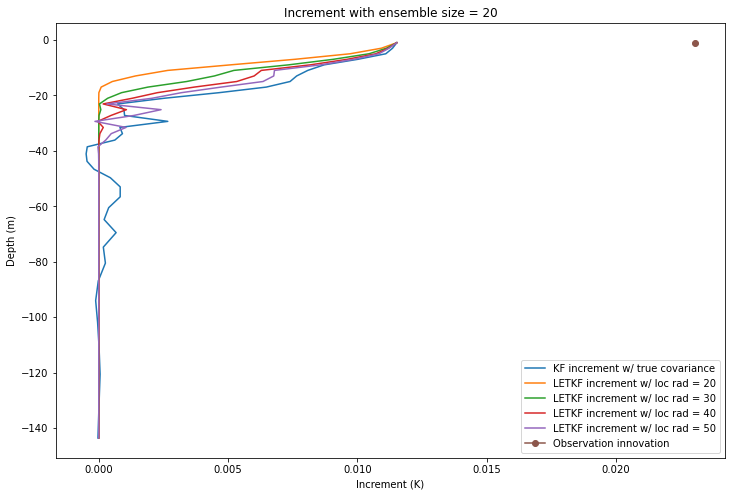

In [195]:
## Plot increment and observation
plt.plot(kf_increment[0,:37], pos_state[:37], label='KF increment w/ true covariance')
plt.plot(inc_loc20[:37], pos_state[:37], label='LETKF increment w/ loc rad = 20')
plt.plot(inc_loc30[:37], pos_state[:37], label='LETKF increment w/ loc rad = 30')
plt.plot(inc_loc40[:37], pos_state[:37], label='LETKF increment w/ loc rad = 40')
plt.plot(inc_loc50[:37], pos_state[:37], label='LETKF increment w/ loc rad = 50')
plt.plot(innovation, pos_ob, marker='o', label='Observation innovation')
plt.legend()
plt.xlabel('Increment (K)')
plt.ylabel('Depth (m)')
plt.title('Increment with ensemble size = '+str(ens_size))

plt.rcParams['figure.figsize'] = [12,8]
#plt.savefig(plot_dir+'/ocn_increment_loc_rad_20to50_150m_ens_size_'+str(ens_size))
plt.show()

In [133]:
## EnKF with localization
dist_state = np.abs(pos_state - pos_ob)
loc_rad = 40
loc = gaspari_cohn((2 * dist_state) / loc_rad)
enkf_increment_with_loc = ((loc * P_ens[0,:])/(2*P_ens[0,0])) * innovation # Note this is not a general formula!

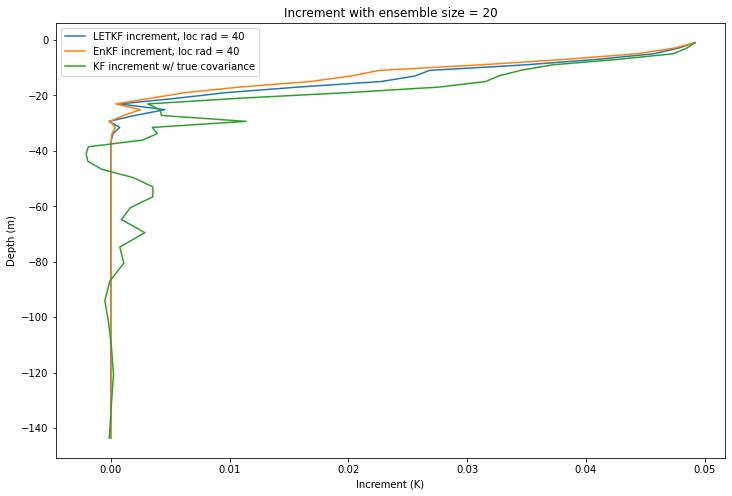

In [176]:
## Compare LETKF and EnKF when we use localization in both schemes

plt.plot(inc_loc40[:37], pos_state[:37], label='LETKF increment, loc rad = 40')
plt.plot(enkf_increment_with_loc[0, :37], pos_state[:37], label='EnKF increment, loc rad = 40')
plt.plot(kf_increment[0,:37], pos_state[:37], label='KF increment w/ true covariance')
plt.legend()
plt.xlabel('Increment (K)')
plt.ylabel('Depth (m)')
plt.title('Increment with ensemble size = '+str(ens_size))

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/ocn_increment_letkf_vs_enkf_with_loc_150m_ens_size_'+str(ens_size))
plt.show()

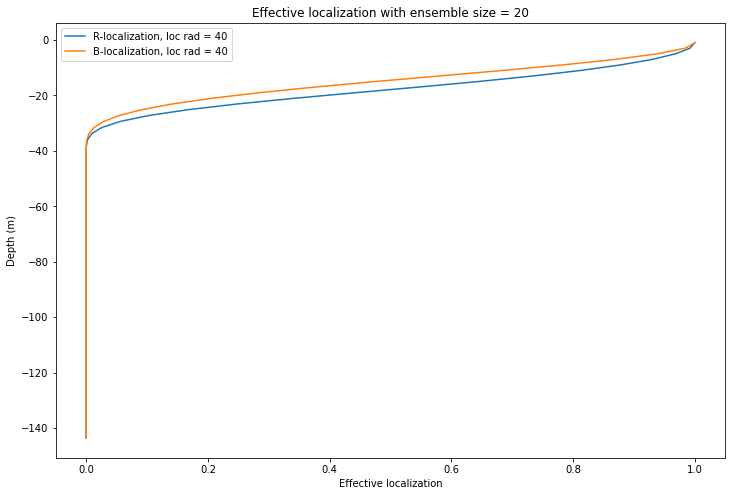

In [177]:
## Compare LETKF and EnKF when we use localization in both schemes

plt.plot(inc_loc40[:37]/inc_no_loc[:37], pos_state[:37], label='R-localization, loc rad = 40')
plt.plot(enkf_increment_with_loc[0, :37]/inc_no_loc[:37], pos_state[:37], label='B-localization, loc rad = 40')
#plt.plot(kf_increment[0,:37], pos_state[:37], label='KF increment w/ true covariance')
plt.legend()
plt.xlabel('Effective localization')
plt.ylabel('Depth (m)')
plt.title('Effective localization with ensemble size = '+str(ens_size))

plt.rcParams['figure.figsize'] = [12,8]
plt.savefig(plot_dir+'/ocn_effective_loc_150m_ens_size_'+str(ens_size))
plt.show()

In [196]:
loc_rads = [1., 5., 20., 30., 40., 50., 60., 70., 80., 90., 100.]
analysis_errs = np.empty_like(loc_rads)

In [197]:
analysis_errs[0] = np.sqrt( np.mean( ( inc_loc1 - kf_increment)**2 ) )
analysis_errs[1] = np.sqrt( np.mean( ( inc_loc5 - kf_increment)**2 ) )
analysis_errs[2] = np.sqrt( np.mean( ( inc_loc20 - kf_increment)**2 ) )
analysis_errs[3] = np.sqrt( np.mean( ( inc_loc30 - kf_increment)**2 ) )
analysis_errs[4] = np.sqrt( np.mean( ( inc_loc40 - kf_increment)**2 ) )
analysis_errs[5] = np.sqrt( np.mean( ( inc_loc50 - kf_increment)**2 ) )
analysis_errs[6] = np.sqrt( np.mean( ( inc_loc60 - kf_increment)**2 ) )
analysis_errs[7] = np.sqrt( np.mean( ( inc_loc70 - kf_increment)**2 ) )
analysis_errs[8] = np.sqrt( np.mean( ( inc_loc80 - kf_increment)**2 ) )
analysis_errs[9] = np.sqrt( np.mean( ( inc_loc90 - kf_increment)**2 ) )
analysis_errs[10] = np.sqrt( np.mean( ( inc_loc100 - kf_increment)**2 ) )

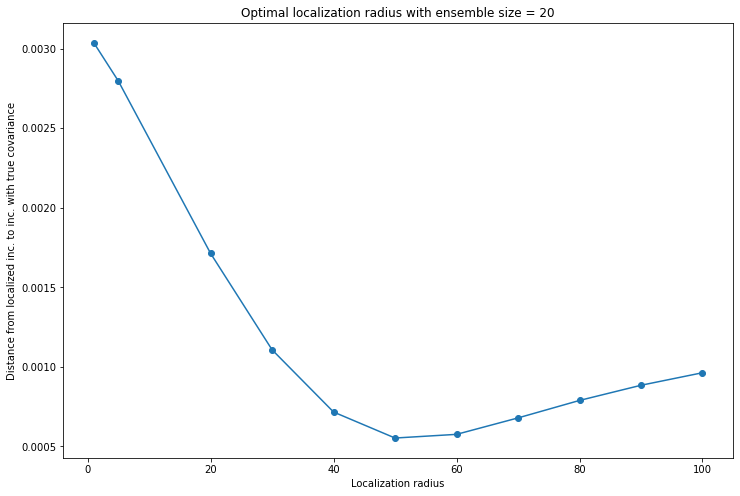

In [198]:
plt.plot(loc_rads, analysis_errs, '-o')
plt.xlabel('Localization radius')
plt.ylabel('Distance from localized inc. to inc. with true covariance')
plt.title('Optimal localization radius with ensemble size = '+str(ens_size))

plt.rcParams['figure.figsize'] = [12,8]
#plt.savefig(plot_dir+'/ocn_optimal_loc_rad_ens_size_'+str(ens_size))
plt.show()